Video loaded: 152 frames at 29 FPS


libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open zink: /usr/lib/dri/zink_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open zink: /usr/lib/dri/zink_dri.so: cannot open shared object file: 

Landmarks extracted: (152, 133)


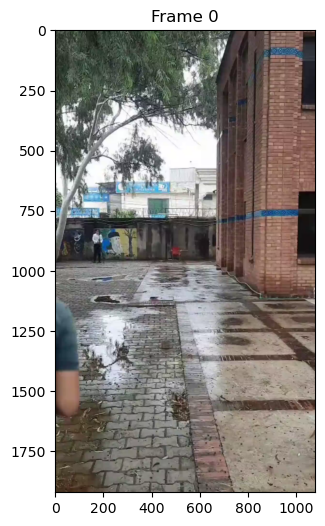

/tmp/ipykernel_154863/3335263354.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_interp["camera"] = df_interp["frame"].apply(assign_camera)


Saved: labeled_pose_video_landmarks.csv
✅ Labeled video saved: labeled_pose_video.mp4


In [7]:
# ---------------------------
# 1. Setup
# ---------------------------
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from scipy.signal import savgol_filter
from mediapipe.framework.formats import landmark_pb2

mp_pose = mp.solutions.pose

# ---------------------------
# 2. Video Loader
# ---------------------------
video_path = "bowling-action.mp4"  # your input video
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Video loaded: {n_frames} frames at {fps} FPS")

# ---------------------------
# 3. Pose Detection (MediaPipe)
# ---------------------------
pose = mp_pose.Pose(min_detection_confidence=0.6, min_tracking_confidence=0.6)
landmarks_data = []

for f in range(n_frames):
    ret, frame = cap.read()
    if not ret:
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb)

    if results.pose_landmarks:
        frame_landmarks = []
        for lm in results.pose_landmarks.landmark:
            frame_landmarks.extend([lm.x, lm.y, lm.z, lm.visibility])
        landmarks_data.append([f] + frame_landmarks)
    else:
        landmarks_data.append([f] + [np.nan] * (33*4))  # 33 body landmarks

cap.release()

cols = ["frame"] + [f"{name}_{axis}" for name in range(33) for axis in ["x","y","z","v"]]
df = pd.DataFrame(landmarks_data, columns=cols)

print("Landmarks extracted:", df.shape)

# ---------------------------
# 4. Interactive Correction
# ---------------------------
current_frame = 0

def plot_frame(frame_idx):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print(f"❌ Could not read frame {frame_idx}")
        return

    row = df.iloc[frame_idx]
    x = [row[f"{i}_x"] for i in range(33)]
    y = [row[f"{i}_y"] for i in range(33)]

    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.scatter(np.array(x)*frame.shape[1], np.array(y)*frame.shape[0], c="red")
    plt.title(f"Frame {frame_idx}")
    plt.show()


# Example usage:
plot_frame(current_frame)

# ---------------------------
# 5. Frame Skipping + Interpolation
# ---------------------------
df_interp = df.interpolate(method="linear", limit_direction="both")

# ---------------------------
# 6. Smoothing (Savitzky–Golay)
# ---------------------------
window = 7  # must be odd
poly = 3
for col in df_interp.columns[1:]:
    df_interp[col] = savgol_filter(df_interp[col].ffill(), window, poly)

# ---------------------------
# 7. (Optional) Camera Tagging
# ---------------------------
# Example: sequential video (0–150 = side, 151–300 = front, 301+ = back)
def assign_camera(frame_idx):
    if frame_idx < 150:
        return "side"
    elif frame_idx < 300:
        return "front"
    else:
        return "back"

df_interp["camera"] = df_interp["frame"].apply(assign_camera)

# ---------------------------
# 8. Export Clean CSV
# ---------------------------
df_interp.to_csv("labeled_pose_video_landmarks.csv", index=False)
print("Saved: labeled_pose_video_landmarks.csv")

# ---------------------------
# 9. Export Labeled Video (with skeleton)
# ---------------------------

output_video = "labeled_pose_video.mp4"

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

for f in range(n_frames):
    ret, frame = cap.read()
    if not ret:
        break

    row = df_interp.iloc[f]

    # Rebuild landmark list for drawing
    landmarks = []
    for i in range(33):
        if not np.isnan(row[f"{i}_x"]) and not np.isnan(row[f"{i}_y"]):
            lm = landmark_pb2.NormalizedLandmark(
                x=row[f"{i}_x"],
                y=row[f"{i}_y"],
                z=row[f"{i}_z"],
                visibility=row[f"{i}_v"]
            )
        else:
            lm = landmark_pb2.NormalizedLandmark(
                x=0, y=0, z=0, visibility=0
            )
        landmarks.append(lm)

    landmark_list = landmark_pb2.NormalizedLandmarkList(
        landmark=landmarks
    )

    # Draw skeleton
    mp_drawing.draw_landmarks(
        frame,
        landmark_list,
        mp_pose.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=3),
        mp_drawing.DrawingSpec(color=(0,0,255), thickness=2)
    )

    # Overlay info
    cv2.putText(frame, f"Frame: {f}", (30, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(frame, f"Camera: {row['camera']}", (30, 80),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 200, 255), 2)

    out.write(frame)

cap.release()
out.release()

print(f"✅ Labeled video saved: {output_video}")

